In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


Loading libraries...

In [2]:
import seaborn as sns
pd.set_option('display.max_rows', 1000)
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from collections import Counter
%pip install ppscore # installing ppscore, library used to check non-linear relationships between our variables
import ppscore as pps # importing ppscore
import string
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
SEED =45
sm = SMOTE(random_state=SEED)
smk=SMOTETomek(random_state=SEED)
rus = RandomUnderSampler(random_state=SEED)
ros = RandomOverSampler(random_state=SEED)
adasyn = ADASYN(random_state=SEED)
logreg = LogisticRegression()
from sklearn.model_selection import train_test_split
from sklearn import metrics
plt.style.use('fivethirtyeight')

  Created wheel for ppscore: filename=ppscore-1.1.1-py2.py3-none-any.whl size=12986 sha256=8633397dd66bc15ece458a146102b6881661f7a2d8e01f90e3b8fead0006ac29
  Stored in directory: /root/.cache/pip/wheels/d0/1f/c4/e619fb20c9b10df8ddde15d583197edef8c2f27d7b1f29c633
Successfully built ppscore
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Loading datasets...

In [3]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
def basic_analysis(df1, df2):
    '''the function compares the average values of  2 dataframes'''
    b = pd.DataFrame()
    b['First df_mean'] = round(df1.mean(),2)
    b['Second df_mean'] = round(df2.mean(),2)
    c = (b['First df_mean']/b['Second df_mean'])
    if [c<=1]:
        b['Variation, %'] = round((1-((b['First df_mean']/b['Second df_mean'])))*100)
    else:
        b['Variation, %'] = round(((b['First df_mean']/b['Second df_mean'])-1)*100)
        
    b['Influence'] = np.where(abs(b['Variation, %']) <= 9, "feature's effect on the target is not defined", 
                              "feature value affects the target")

    return b

In [6]:
## thanks to @Nadezda Demidova  https://www.kaggle.com/demidova/titanic-eda-tutorial-with-seaborn
train.loc[train['PassengerId'] == 631, 'Age'] = 48

# Passengers with wrong number of siblings and parch
train.loc[train['PassengerId'] == 69, ['SibSp', 'Parch']] = [0,0]
test.loc[test['PassengerId'] == 1106, ['SibSp', 'Parch']] = [0,0]

In [7]:
## checking for Survived dependence of Sex feature
train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [8]:
## checking for Survived dependence of Sex feature
train[["Pclass", "Survived"]].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [9]:
## checking for Survived dependence of Sex feature
train[["Embarked", "Survived"]].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


In [10]:
## let's concatenate test and train datasets excluding ID and Target features
df = pd.concat((train.loc[:,'Pclass':'Embarked'], test.loc[:,'Pclass':'Embarked'])).reset_index(drop=True)

In [11]:
## for Age imputation let's check its dependence from Pclass
pd.DataFrame(df.groupby('Pclass')['Age'].describe())

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,284.0,39.047254,14.353217,0.92,28.0,39.0,49.25,76.0
2,261.0,29.506705,13.638627,0.67,22.0,29.0,36.00,70.0
3,501.0,24.816367,11.958202,0.17,18.0,24.0,32.00,74.0


In [12]:
# New Title feature
df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
df['Title'] = df['Title'].map(title_mapping)
df['Title'] = df['Title'].fillna(0)

##dropping Name feature
df = df.drop(['Name'], axis=1)

# Convert 'Sex' variable to integer form!
df["Sex"][df["Sex"] == "male"] = 0
df["Sex"][df["Sex"] == "female"] = 1
df["Sex"] = df["Sex"].astype(int)

## Age tuning:
df['Age'] = df.groupby(['Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))
df["Age"] = df["Age"].astype(int)

# df['Age_cat'] = pd.qcut(df['Age'],q=[0, .16, .33, .49, .66, .83, 1], labels=False, precision=1)

# Ticket tuning
tickets = []
for i in list(df.Ticket):
    if not i.isdigit():
        tickets.append(i.replace(".","").replace("/","").strip().split(" ")[0])
    else:
        tickets.append("x")
df["Ticket"] = tickets
# df['Ticket_Frequency'] = df.groupby('Ticket')['Ticket'].transform('count')
df = pd.get_dummies(df, columns= ["Ticket"], prefix = "T")


## Fare tuning:
df['Fare'] = df.groupby("Pclass")['Fare'].transform(lambda x: x.fillna(x.median())) 
df['Zero_Fare'] = df['Fare'].map(lambda x: 1 if x == 0 else (0))


def fare_category(fr): 
    if fr <= 7.91:
        return 1
    elif fr <= 14.454 and fr > 7.91:
        return 2
    elif fr <= 31 and fr > 14.454:
        return 3
    return 4

df['Fare_cat'] = df['Fare'].apply(fare_category)

# Replace missing values with 'U' for Cabin
df['Cabin'] = df['Cabin'].fillna('U')
import re
# Extract first letter
df['Cabin'] = df['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
cabin_category = {'A':9, 'B':8, 'C':7, 'D':6, 'E':5, 'F':4, 'G':3, 'T':2, 'U':1}
# Mapping 'Cabin' to group
df['Cabin'] = df['Cabin'].map(cabin_category)


df["Embarked"] = df["Embarked"].fillna("C")
df["Embarked"][df["Embarked"] == "S"] = 1
df["Embarked"][df["Embarked"] == "C"] = 2
df["Embarked"][df["Embarked"] == "Q"] = 3
df["Embarked"] = df["Embarked"].astype(int)

# New 'familySize' feature & dripping 2 features:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

df['SmallF'] = df['FamilySize'].map(lambda s: 1 if  s == 2  else 0)
df['MedF']   = df['FamilySize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
df['LargeF'] = df['FamilySize'].map(lambda s: 1 if s >= 5 else 0)

df['Senior'] = df['Age'].map(lambda s:1 if s>70 else 0)
df['FareCat_Sex'] = df['Fare_cat']*df['Sex']
df['Pcl_Sex'] = df['Pclass']*df['Sex']
df['Pcl_Title'] = df['Pclass']*df['Title']
df['Title_Sex'] = df['Title']*df['Sex']
df['Rich_woman'] = 0
df['Men_3Class'] = 0
df.loc[(df['Pclass']<=2) & (df['Sex']==0), 'Rich_woman'] = 1
df.loc[(df['Pclass']==3) & (df['Sex']==1), 'Men_3Class'] = 1
df['Rich_woman'] = df['Rich_woman'].astype(np.int8)
df['Alone'] = [1 if i == 1 else 0 for i in df['FamilySize']]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipyk

In [13]:
## adding new featrures
def des_stat_feat(df):
    df = pd.DataFrame(df)
    dcol= [c for c in df.columns if df[c].nunique()>=10]
    d_median = df[dcol].median(axis=0)
    d_mean = df[dcol].mean(axis=0)
    q1 = df[dcol].apply(np.float32).quantile(0.25)
    q3 = df[dcol].apply(np.float32).quantile(0.75)
    
    #Add mean and median column to data set having more then 3 categories
    for c in dcol:
        df[c+str('_median_range')] = (df[c].astype(np.float32).values > d_median[c]).astype(np.int8)
        df[c+str('_mean_range')] = (df[c].astype(np.float32).values > d_mean[c]).astype(np.int8)
        df[c+str('_q1')] = (df[c].astype(np.float32).values < q1[c]).astype(np.int8)
        df[c+str('_q3')] = (df[c].astype(np.float32).values > q3[c]).astype(np.int8)
    return df

df = des_stat_feat(df) 

In [14]:
def reduce_memory_usage(df):
    """ The function will reduce memory of dataframe
    Note: Apply this function after removing missing value"""
    intial_memory = df.memory_usage().sum()/1024**2
    print('Intial memory usage:',intial_memory,'MB')
    for col in df.columns:
        mn = df[col].min()
        mx = df[col].max()
        if df[col].dtype != object:            
            if df[col].dtype == int:
                if mn >=0:
                    if mx < np.iinfo(np.uint8).max:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < np.iinfo(np.uint16).max:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < np.iinfo(np.uint32).max:
                        df[col] = df[col].astype(np.uint32)
                    elif mx < np.iinfo(np.uint64).max:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
            if df[col].dtype == float:
                df[col] =df[col].astype(np.float32)
    
    red_memory = df.memory_usage().sum()/1024**2
    print('Memory usage after complition: ',red_memory,'MB')
    
reduce_memory_usage(df)

Intial memory usage: 0.28225135803222656 MB
Memory usage after complition:  0.0937490463256836 MB


In [15]:
#creating matrices for feature selection:
X_train = df[:train.shape[0]]
X_test_fin = df[train.shape[0]:]
y = train.Survived
X_train['Survived'] = y
df = X_train

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [16]:
# check and remove constant columns
colsToRemove = []
for col in df.columns:
    if df[col].std() == 0.00: 
        colsToRemove.append(col)
        
# remove constant columns in the training set
df.drop(colsToRemove, axis=1, inplace=True)
X_test_fin.drop(colsToRemove, axis=1, inplace=True)
print("Removed `{}` Constant Columns\n".format(len(colsToRemove)))
print(colsToRemove)

Removed `6` Constant Columns

['T_A', 'T_AQ3', 'T_AQ4', 'T_LP', 'T_SCA3', 'T_STONOQ']


In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pclass,891.0,2.308642,0.836071,1.0,2.0000,3.0000,3.0,3.000000
Sex,891.0,0.352413,0.477990,0.0,0.0000,0.0000,1.0,1.000000
Age,891.0,29.081930,13.203124,0.0,22.0000,26.0000,37.0,74.000000
SibSp,891.0,0.518519,1.096698,0.0,0.0000,0.0000,1.0,8.000000
Parch,891.0,0.379349,0.804328,0.0,0.0000,0.0000,0.0,6.000000
Fare,891.0,32.204247,49.693409,0.0,7.9104,14.4542,31.0,512.329224
Cabin,891.0,2.283951,2.460739,1.0,1.0000,1.0000,1.0,9.000000
Embarked,891.0,1.363636,0.636159,1.0,1.0000,1.0000,2.0,3.000000
Title,891.0,1.728395,1.030039,1.0,1.0000,1.0000,2.0,5.000000
T_A4,891.0,0.007856,0.088337,0.0,0.0000,0.0000,0.0,1.000000


Outlier detection

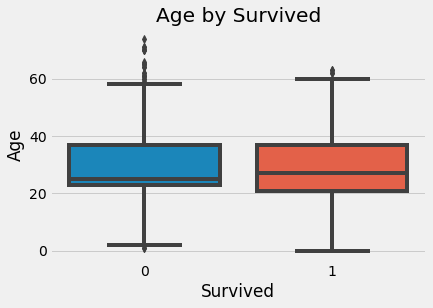

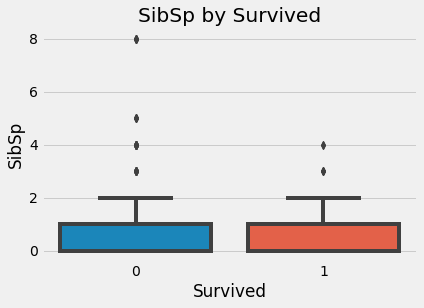

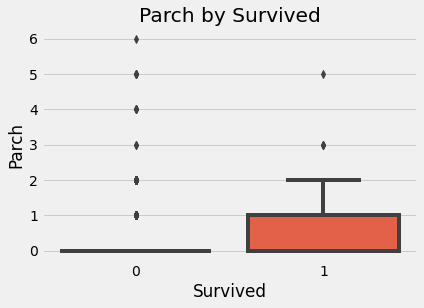

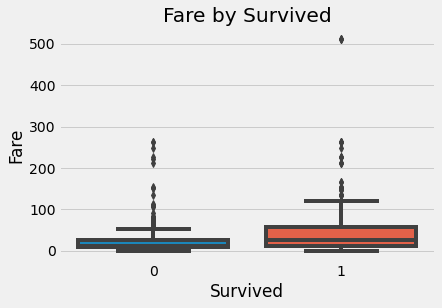

In [18]:
## distribution and checking for outliers in numeric features
import matplotlib.pyplot as plt
features = df[['Age', 'SibSp', 'Parch', 'Fare']].columns
for i in features:
    sns.boxplot(x="Survived",y=i,data=df)
    plt.title(i+" by "+"Survived")
    plt.show()

Distribution of cat features....

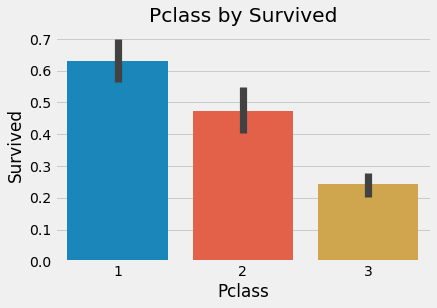

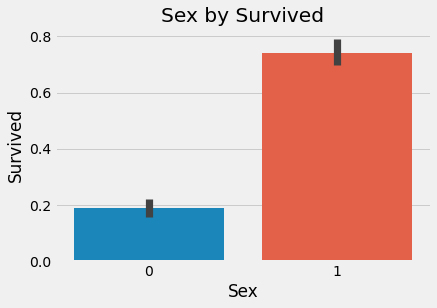

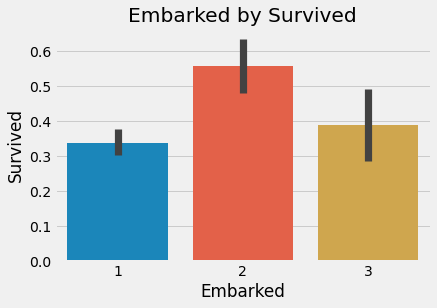

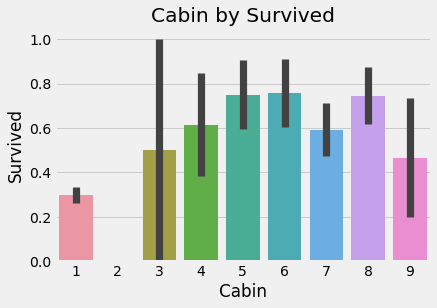

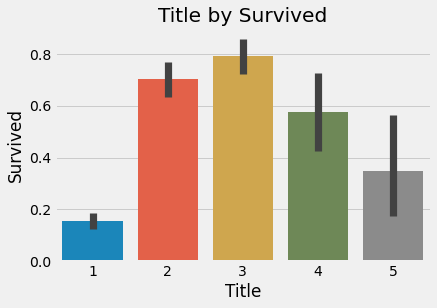

In [19]:
## distribution of cat features
cat_features = df[['Pclass', 'Sex', 'Embarked', 'Cabin', 'Title']].columns
for i in cat_features:
    sns.barplot(y="Survived",x=i,data=df)
    plt.title(i+" by "+"Survived")
    plt.show()

In [20]:
# var = df.drop(['Survived'], axis=1).columns.values

# i = 0
# t0 = df.loc[df['Survived'] == 0]
# t1 = df.loc[df['Survived'] == 1]

# sns.set_style('whitegrid')
# plt.figure()
# fig, ax = plt.subplots(5,12,figsize=(22,28))

# for feature in var:
#     i += 1
#     plt.subplot(5,12,i)
#     sns.kdeplot(t0[feature], bw=0.5,label="Survived = 0")
#     sns.kdeplot(t1[feature], bw=0.5,label="Survived = 1")
#     plt.xlabel(feature, fontsize=12)
#     locs, labels = plt.xticks()
#     plt.tick_params(axis='both', which='major', labelsize=12)
# plt.show();

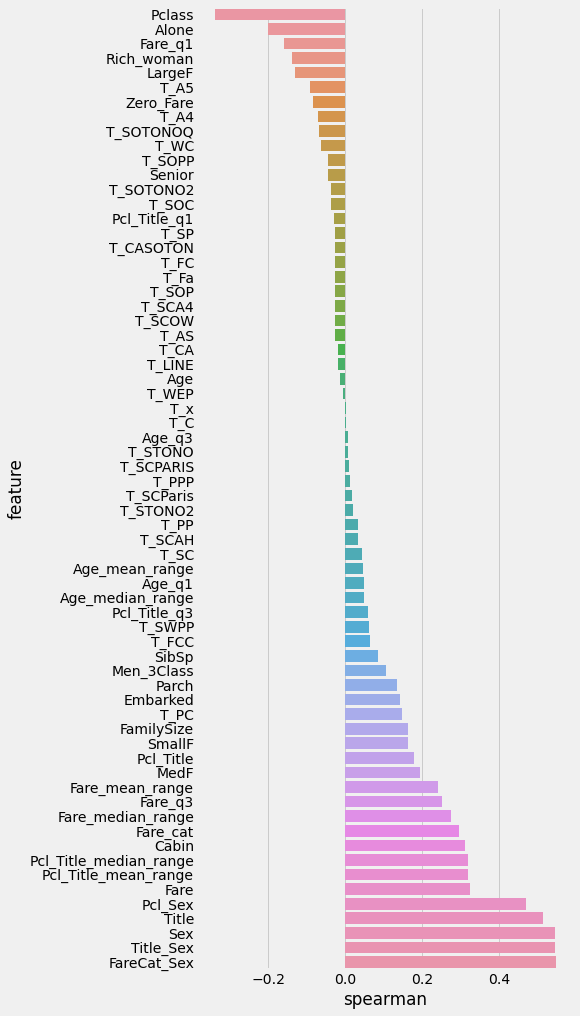

In [21]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['Survived'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = df.drop(['Survived'], axis=1).columns
spearman(df, features)

In [22]:
def basic_details(df):
    b = pd.DataFrame()
    b['Missing value, %'] = round(df.isnull().sum()/df.shape[0]*100)
    b['N unique value'] = df.nunique()
    b['dtype'] = df.dtypes
    return b
basic_details(df)

,"Missing value, %",N unique value,dtype
Pclass,0.0,3,uint8
Sex,0.0,2,uint8
Age,0.0,70,uint8
SibSp,0.0,7,uint8
Parch,0.0,7,uint8
Fare,0.0,248,float32
Cabin,0.0,9,uint8
Embarked,0.0,3,uint8
Title,0.0,5,uint8
T_A4,0.0,2,uint8


Model Tuning....

In [23]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler

X = df.drop('Survived', axis=1)
y = df.Survived

x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=SEED)
x_train, y_train= ros.fit_resample(x_train, y_train)

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
d_test = xgb.DMatrix(X_test_fin)


In [24]:
params = {
        'objective':'binary:hinge',
        'max_depth':13, # first pair to tune from 0 to 13
        'learning_rate':0.1, # 4th to tune
        'eval_metric':'auc',
        'min_child_weight':7, # first pair to tune from 0 to 12
        'subsample':0.8,
        'colsample_bytree':0.8,
        'seed':29,
#         'reg_lambda':1,
        'reg_alpha':0, ## 3rd to tune 
        'gamma':0, # second for tune with step 0.1 from 0 to 0.5
        'scale_pos_weight':1,
        'n_estimators': 5000,
        'nthread':-1
}

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
nrounds=10000  
model = xgb.train(params, d_train, nrounds, watchlist, early_stopping_rounds=50, 
                           maximize=True, verbose_eval=10)
from sklearn import metrics

y_pred = model.predict(d_valid)
print('Accuracy :{0:0.5f}'.format(metrics.accuracy_score(y_valid, y_pred))) 
print('AUC : {0:0.5f}'.format(metrics.roc_auc_score(y_valid, y_pred)))
print('Precision : {0:0.5f}'.format(metrics.precision_score(y_valid, y_pred)))
print('Recall : {0:0.5f}'.format(metrics.recall_score(y_valid, y_pred)))
print('F1 : {0:0.5f}'.format(metrics.f1_score(y_valid, y_pred)))

[13:23:57] WARNING: /workspace/src/learner.cc:480: 
Parameters: { n_estimators, scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.50000	valid-auc:0.50000
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[10]	train-auc:0.84375	valid-auc:0.79680
[20]	train-auc:0.88542	valid-auc:0.84857
[30]	train-auc:0.90278	valid-auc:0.86187
[40]	train-auc:0.91551	valid-auc:0.87848
[50]	train-auc:0.92014	valid-auc:0.88227
[60]	train-auc:0.92824	valid-auc:0.89082
[70]	train-auc:0.93750	valid-auc:0.89082
[80]	train-auc:0.94213	valid-auc:0.90316
[90]	train-auc:0.94329	valid-auc:0.90364
[100]	train-auc:0.94560	valid-auc:0.90364
[110]	train-auc:0.95023	valid-auc:0.91598
[120]	

Final model's accuracy:

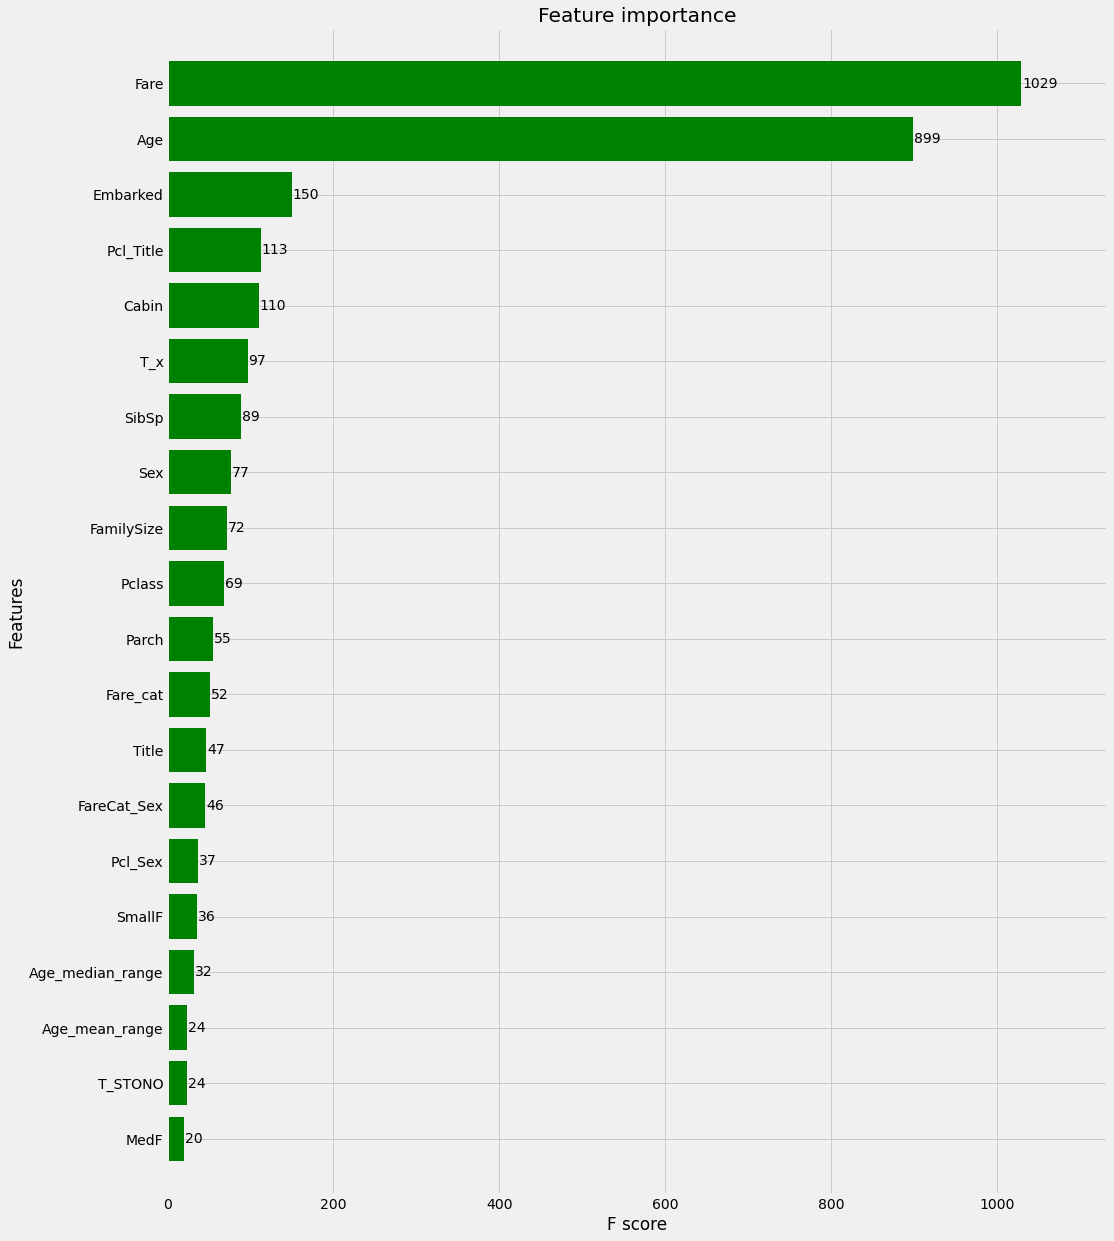

In [25]:
fig,ax = plt.subplots(figsize=(15,20))
xgb.plot_importance(model,ax=ax,max_num_features=20,height=0.8,color='g')
# plt.tight_layout()
plt.show()

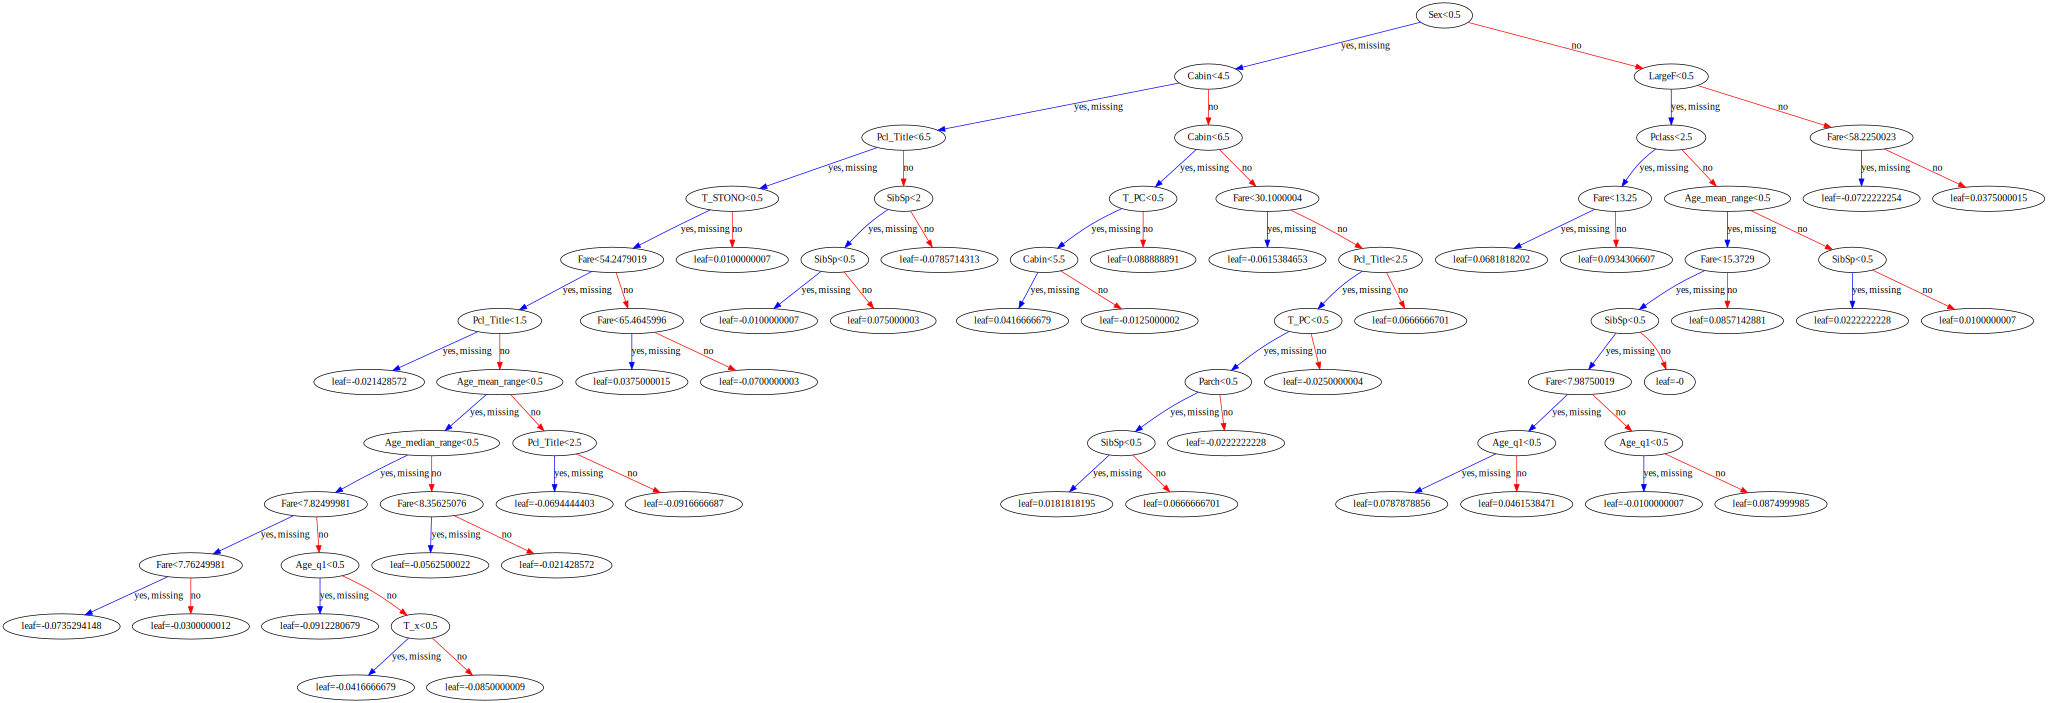

In [26]:
xgb.to_graphviz(model)

In [27]:
# leaks = {
# 897:1,
# 899:1, 
# 930:1,
# 932:1,
# 949:1,
# 987:1,
# 995:1,
# 998:1,
# 999:1,
# 1016:1,
# 1047:1,
# 1083:1,
# 1097:1,
# 1099:1,
# 1103:1,
# 1115:1,
# 1118:1,
# 1135:1,
# 1143:1,
# 1152:1, 
# 1153:1,
# 1171:1,
# 1182:1,
# 1192:1,
# 1203:1,
# 1233:1,
# 1250:1,
# 1264:1,
# 1286:1,
# 935:0,
# 957:0,
# 972:0,
# 988:0,
# 1004:0,
# 1006:0,
# 1011:0,
# 1105:0,
# 1130:0,
# 1138:0,
# 1173:0,
# 1284:0,
# }

In [28]:
sub = pd.DataFrame()
sub['PassengerId'] = test['PassengerId']
sub['Survived'] = model.predict(d_test)
sub['Survived'] = sub['Survived'].apply(lambda x: 1 if x>0.8 else 0)
# sub['Survived'] = sub.apply(lambda r: leaks[int(r['PassengerId'])] if int(r['PassengerId']) in leaks else r['Survived'], axis=1)
sub.to_csv('submission.csv', index=False)

sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1


In [29]:
## Dmatrix crossvalscore
dmatrix_data = xgb.DMatrix(data=x_train, label=y_train)
cross_val = xgb.cv(
    params=params,
    dtrain=dmatrix_data, 
    nfold=3,
    num_boost_round=500, 
    early_stopping_rounds=500, 
    metrics='auc', 
    as_pandas=True, 
    seed=29)
cross_val.max()

[13:23:59] WARNING: /workspace/src/learner.cc:480: 
Parameters: { n_estimators, scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:23:59] WARNING: /workspace/src/learner.cc:480: 
Parameters: { n_estimators, scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:23:59] WARNING: /workspace/src/learner.cc:480: 
Parameters: { n_estimators, scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip thr

train-auc-mean    0.978579
train-auc-std     0.021112
test-auc-mean     0.855370
test-auc-std      0.025053
dtype: float64